In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

Precompiling packages...
  31102.1 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 37 seconds. 509 already precompiled.


In [66]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [158]:
function do_single(Ns, Nr, params, lst, extinctthreshold, maxresidwarn)
    # numerically solve for the steady state
    u0 = ModifiedMiCRM.make_u0_maxNs(params)
    ssp = make_mmicrm_ss_problem(params, u0)
    ssps = solve(ssp, DynamicSS(QNDF()); reltol=maxresidwarn / 1000)

    if SciMLBase.successful_retcode(ssps.retcode)
        warning = false
        maxresid = maximum(abs, ssps.resid)
        if maxresid > maxresidwarn
            @printf "maxresid reached is %f > %f" maxresid maxresidwarn
            warning = true
        end

        if all(x->abs(x) < extinctthreshold, ssps.u[1:Ns])
            return -101
        end

        linstab_result = lst(params, ssps.u)
        if !warning
            if linstab_result 
                return 2 # spatial instability
            else
                return 1 # stable
            end
        else
            if linstab_result 
               return -2 # spatial instability but may be wrong
            else
                return -1 # stable but may be wrong
            end
        end
        
    else
        return -100
    end
end

function do_rg_run(rg, num_repeats, ks;
        extinctthreshold=1e-8,
        maxresidwarn=1e-5
    )
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester(ks, N)

    rslts = fill(0, num_repeats)
    @tasks for i in 1:num_repeats
        @local llst = copy(lst)
        
        params = rg()

        rslts[i] = do_single(Ns, Nr, params, llst, extinctthreshold, maxresidwarn)
        
        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    rslts
end

do_rg_run (generic function with 1 method)

# Testing

In [159]:
srgj = SRGJans1(50, 50;
    m=0.8,
    r=1.,
    Kp=0.1, K=1.0,
    
    c=3.,
    l=0.9,
    sparsity_resources=0.5,
    sparsity_byproducts=1.,
    
    DS=1.e-5, DR=1.,
)
@time xx = do_rg_run(srgj, nthreads(), LinRange(0., 100., 1000))
freqtable(xx)

Generating one params: 0.001182 seconds (3.87 k allocations: 2.806 MiB)
  5.419981 seconds (58.12 M allocations: 2.717 GiB, 4.19% gc time, 21.14% compilation time)


2-element Named Vector{Int64}
Dim1  │ 
──────┼───
-101  │  3
1     │ 15

In [118]:
ps = srgj();

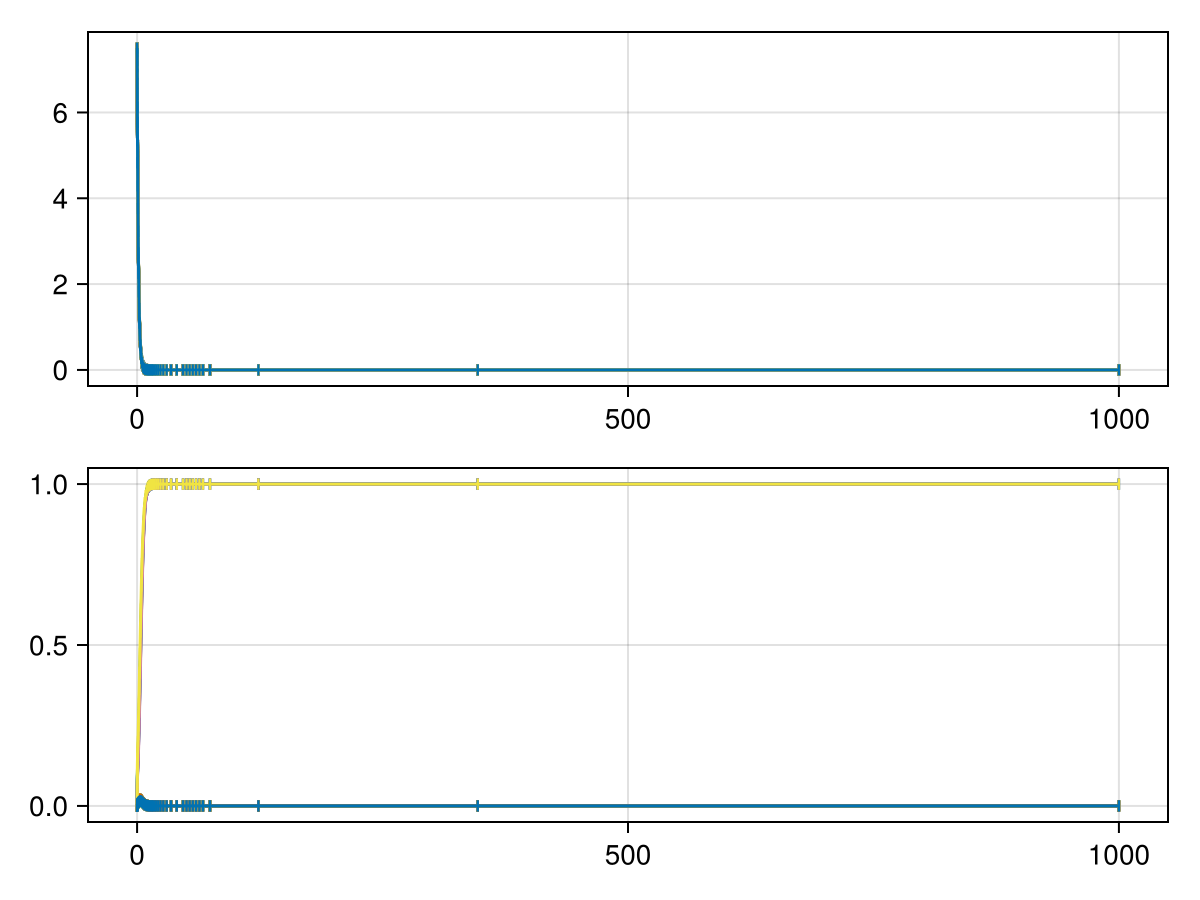

In [119]:
u0 = make_u0_smart(ps; u0=:maxNs);
p = make_mmicrm_problem(ps, u0, 1000);

s = solve(p)
f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

# ODE/PDE Solving

In [34]:
usol = s[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-2.1184529390838712e-10, -1.4571518519552614e-21, 1.571107739745853e-34, 1.220999770751812e-10, 3.263674563599057e-33, -9.962763670471997e-33, 1.696777691416426e-33, 1.1899404451158281e-24, 3.813073088806353e-33, 6.142771122437004e-34, 6.289056972727341e-25, -2.175950156186939e-31, 1.429373401642622e-10, -7.152455355313113e-12, 2.1140117838591763e-33, 9.963519130065664e-29, 3.0810308165383327e-33, 2.9018209930680758e-33, 2.752172593327398e-29, -1.8368566153254166e-31, -3.3244761110662324e-12, -3.47648992926608e-12, 1.6976454964012788e-12, -2.5768363137723682e-12, 1.5995087199183189e-12, 3.4827488115674043e-12, -3.1474224268523976e-11, 3.1327614113951796e-12, 1.377013780778924e-11, 1.1948570605158082e-11, 7.481973374190432e-12, -7.490312189939452e-12, -2.9640248588869156e-12, -1.6428153976066895e-11, -3.96044308459409e-12, 1.0617347279140432e-11, -1.8317417027624572e-11, 1.218503076216848e-11, -2.1820129036953517e-11, -9.355932695243041e-12]

maximum(real(lambdas)) = -0.0005409153668305567
stable :(


┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.431979
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.431979
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.414429
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.347324
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.314030
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.135522
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 

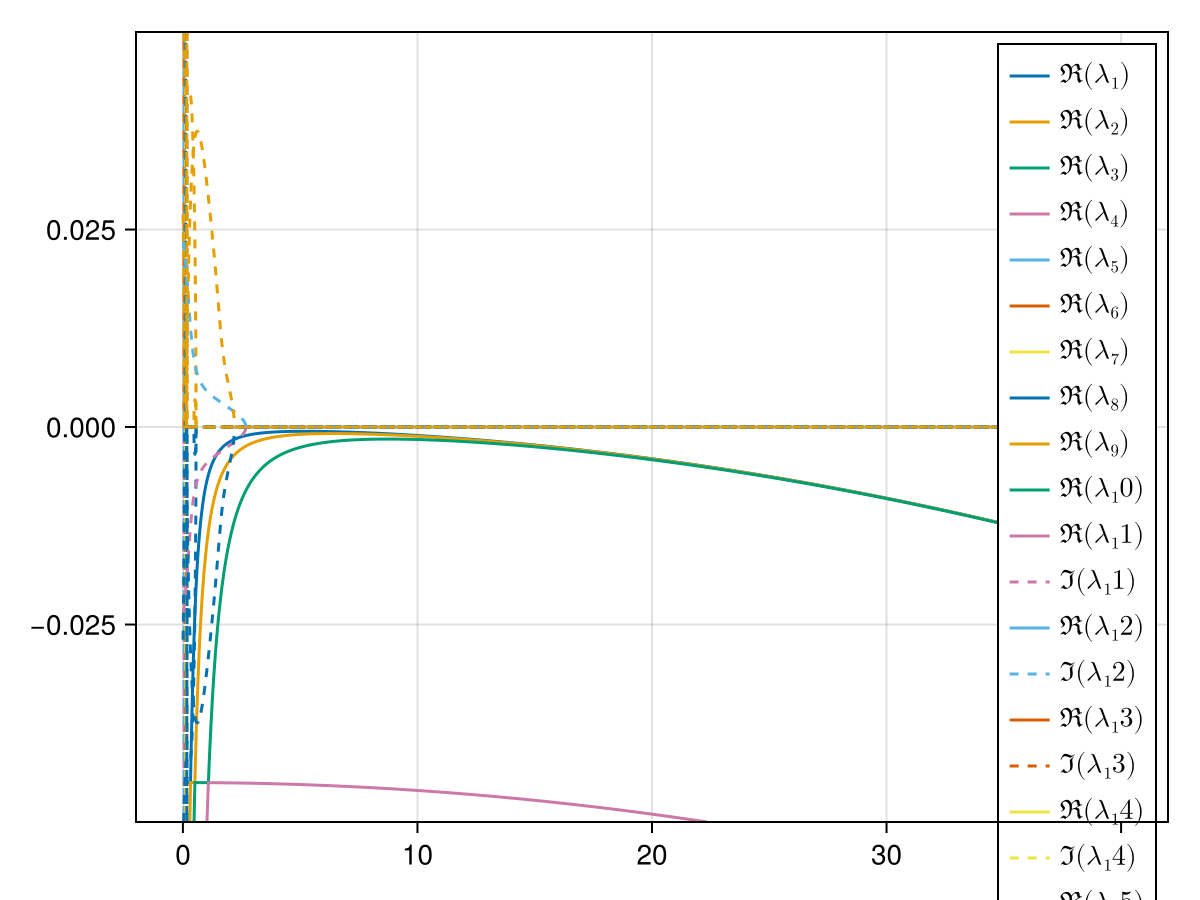

In [35]:
ks = LinRange(0., 40., 10000)
#Ds = [1e-5,1e-5, 500, 10, 10]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
if maximum(real(lambdas)) > 0
    println("unstable!")
else
    println("stable :(")
end
# plot the eigenvalues
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [36]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(1301, 5.200520052005201)

In [37]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

40-element Vector{Float64}:
  7.678795901755043e-11
 -1.5287476058004548e-14
 -1.1569115698117492e-15
 -0.1531526255524264
 -1.5821030496608528e-15
  1.7433734802405055e-15
 -2.394325053660124e-15
  1.9133839300778204e-14
 -2.1801901232078654e-15
 -9.060113871306316e-15
  ⋮
 -5.50912650394116e-6
  7.307279116008911e-5
  0.0013419983638799733
 -9.909855921442162e-6
 -1.1861901245853124e-5
  0.00015384317984630617
 -0.000351784453005699
 -0.00014414240582337134
  0.00013833782015640502

## Probability of instability!

In [38]:
# We are going to run a set of replicates to see how probable instability is
nrep = 100

S = 20
M = 20  

instability = fill(0., nrep)

for ii in 1:nrep
    # initialize the parameters
    r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

    # create the model
    p = make_mmicrm_smart(S, M, 500;
        D, c, l,
        K,r,m,
        u0=:onlyN,
        u0rand=0.
    )
    s = solve(p)

    usol = s[end]

    # check the stability
    ks = LinRange(0., 40., 10000)
    lambdas = do_linstab_for_ks(ks, p, Ds, usol);

    if maximum(real(lambdas)) > 0
        instability[ii] = 1.
    else
        instability[ii] = 0.
    end
    #println("replicate ", ii, " of ", nrep, " done")
end

println("fraction instability: ", sum(instability)/nrep)


fraction instability: 0.14


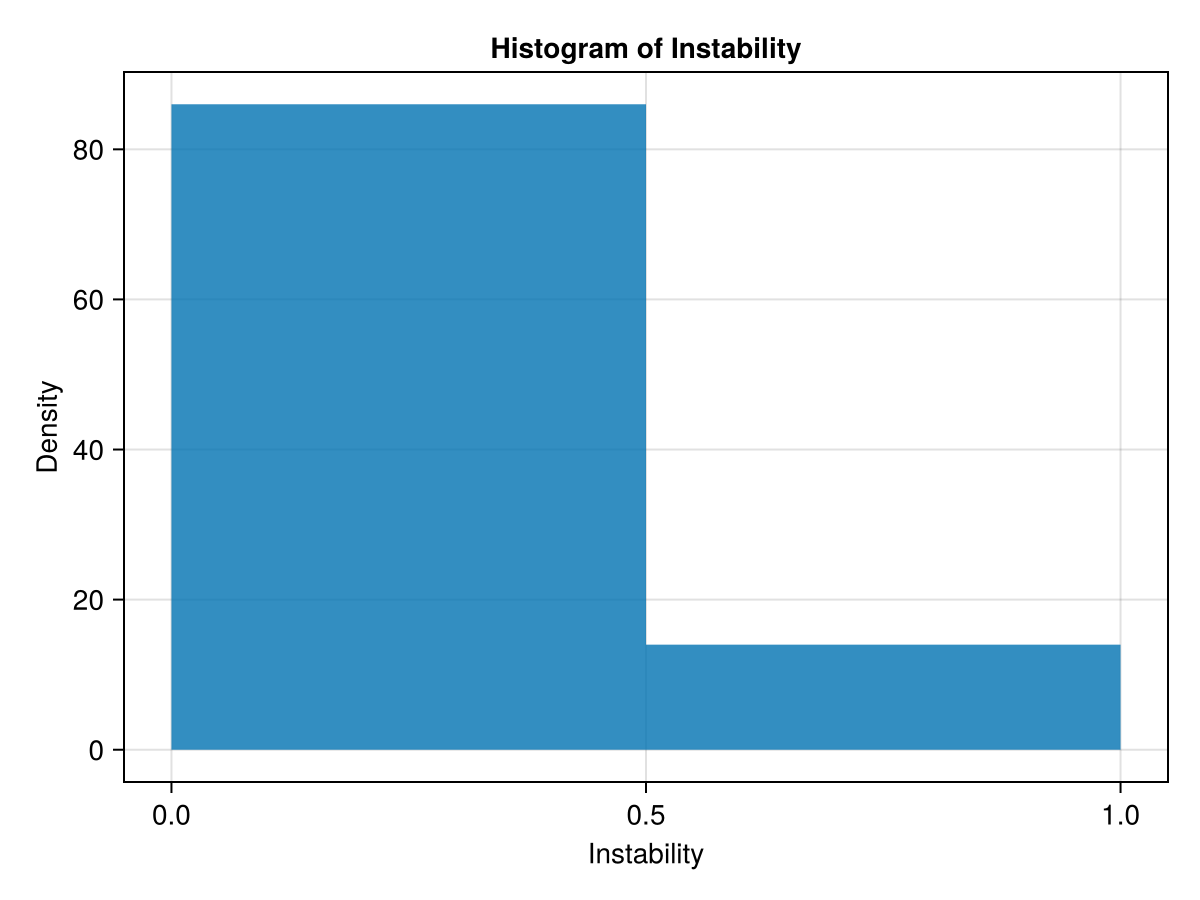

In [39]:
# check the histogram of instability
f = Figure()
ax = Axis(f[1, 1], title="Histogram of Instability", xlabel="Instability", ylabel="Density")
hist!(ax, instability, bins=2)#, normalization = :pdf)
f

In [43]:
# Now we'll see % instability as a function of size

species = [2, 5, 10, 15, 20]
nspecies = length(species)

perc_instability = fill(0., nspecies)


for x in 1:nspecies

    println(x)
    nrep = 100

    S = species[x]
    M = species[x]

    println(S, " species")
    println(M, " resources")

    instability = fill(0., nrep)

    for ii in 1:nrep
        # initialize the parameters
        r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

        # create the model
        p = make_mmicrm_smart(S, M, 500;
            D, c, l,
            K,r,m,
            u0=:onlyN,
            u0rand=0.
        )
        s = solve(p)

        usol = s[end]

        # check the stability
        ks = LinRange(0., 40., 10000)
        lambdas = do_linstab_for_ks(ks, p, Ds, usol);

        if maximum(real(lambdas)) > 0
            instability[ii] = 1.
        else
            instability[ii] = 0.
        end
        #println("replicate ", ii, " of ", nrep, " done")
    end
    println("finished replicates for ", S, " species")

    println("fraction instability: ", sum(instability)/nrep)
    perc_instability[x] = sum(instability)/nrep
end

1
2 species
2 resources
finished replicates for 2 species
fraction instability: 0.03
2
5 species
5 resources
finished replicates for 5 species
fraction instability: 0.02
3
10 species
10 resources
finished replicates for 10 species
fraction instability: 0.08
4
15 species
15 resources
finished replicates for 15 species
fraction instability: 0.05
5
20 species
20 resources
finished replicates for 20 species
fraction instability: 0.09


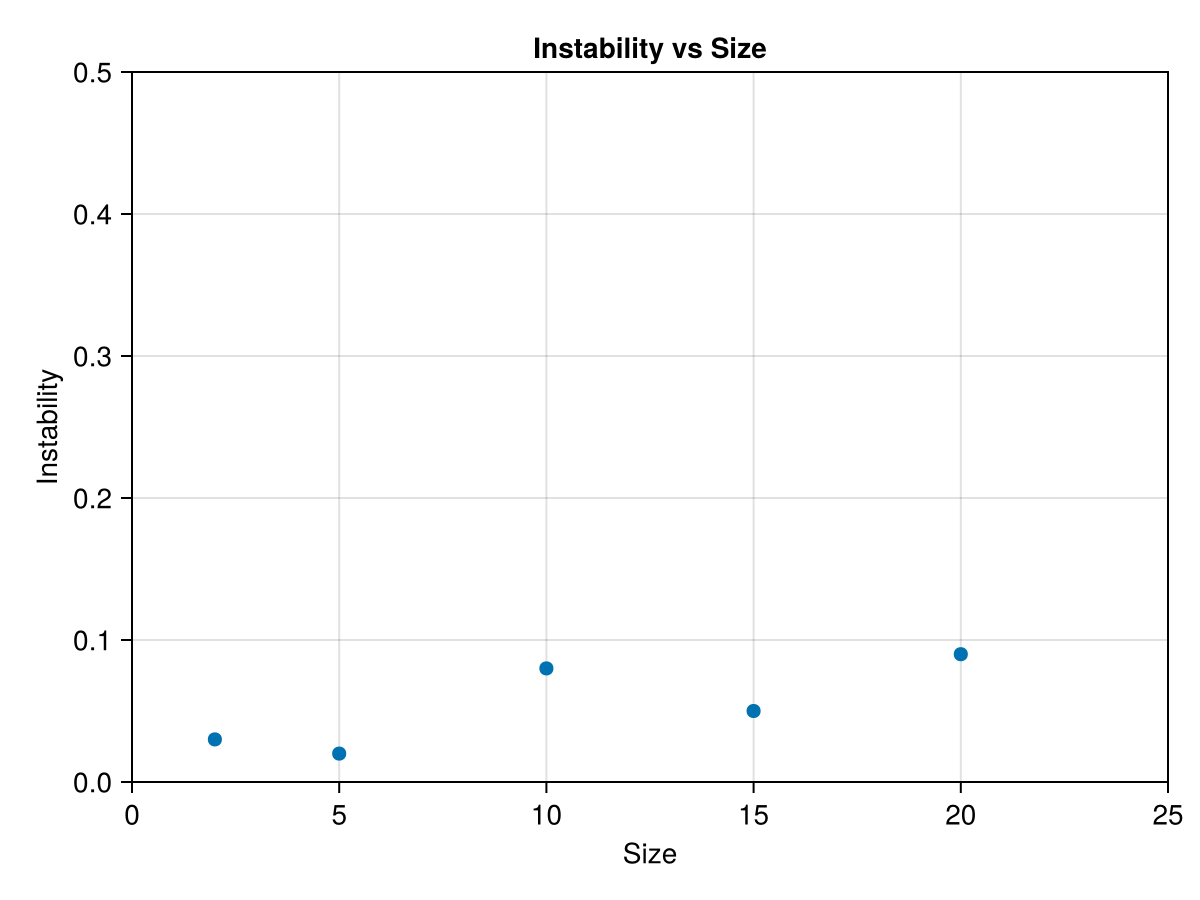

In [45]:
# plot the results
f = Figure()
ax = Axis(f[1, 1], title="Instability vs Size", xlabel="Size", ylabel="Instability")
scatter!(ax, species, perc_instability, markersize=10)
ylims!(ax, (0., 0.5))
xlims!(ax, (0., 25.))
f

In [55]:
# now let's see how the instability changes with sparsity and average leakage

nc = 5
nl = 5

repeats = 3
nrep = 20

instability = fill(0., (nc,nl,repeats,nrep))

for i in 1:nc
    c_sparsity = i/nc
    for j in 1:nl
        l_sparsity = j/nl
        for k in 1:repeats
            for q in 1:nrep
          
                # initialize the parameters
                S = 10
                M = 10

                r, m, K, l, c, D, Ds = random_matrix_initialization(S,M,c_sparsity,l_sparsity)

                # create the model
                p = make_mmicrm_smart(S, M, 500;
                    D, c, l,
                    K,r,m,
                    u0=:onlyN,
                    u0rand=0.
                )
                s = solve(p)
                usol = s[end]
                # check the stability
                ks = LinRange(0., 40., 10000)
                lambdas = do_linstab_for_ks(ks, p, Ds, usol)
                if maximum(real(lambdas)) > 0
                    instability[i,j,k,q] = 1.
                else
                    instability[i,j,k,q] = 0.
                end
                #println("replicate ", ii, " of ", nrep, " done")
            end
        end
    
    end
end



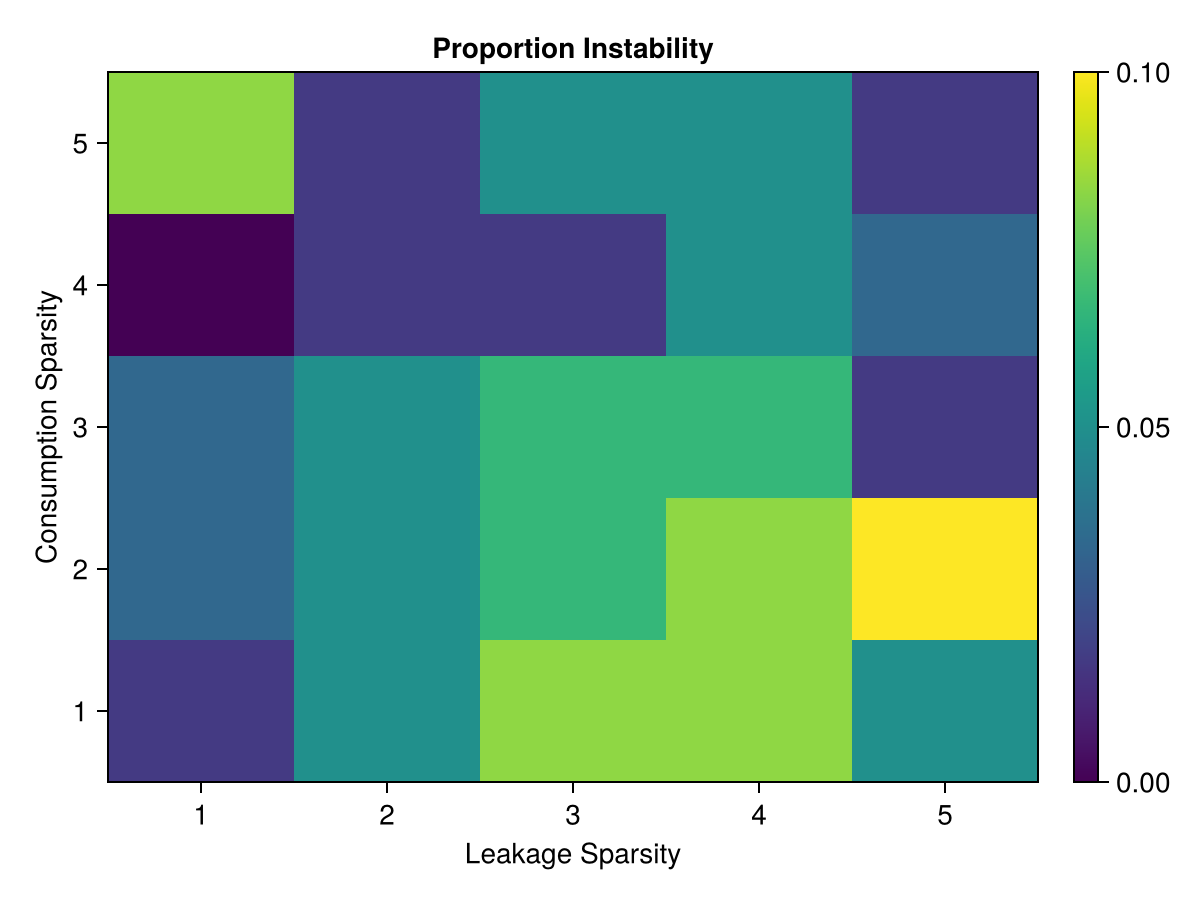

In [57]:
# lets plot the heatmap

# first we need to average over the repeats
instability_avg = fill(0., (nc,nl))
for i in 1:nc
    for j in 1:nl
        instability_avg[i,j] = sum(instability[i,j,:,:])/(repeats*nrep)
    end
end

# now we can plot the heatmap
fig, ax, hm = heatmap(instability_avg, colormap = :viridis, axis = (title = "Proportion Instability", xlabel = "Leakage Sparsity", ylabel = "Consumption Sparsity"))
Colorbar(fig[:, end+1], hm)
fig



# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()